<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [ ]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving content.jpeg to content.jpeg

Upload Style Image


Saving style2.jpeg to style2.jpeg
Content Path: <_io.BytesIO object at 0x7f2363b3ce30>
Style Path: <_io.BytesIO object at 0x7f2381de8230>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

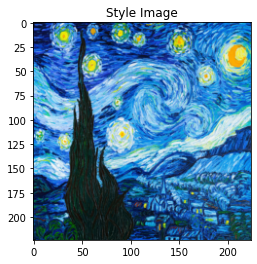

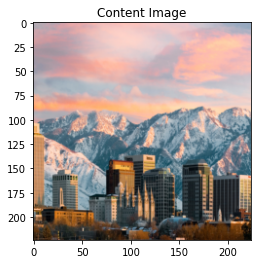

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates


In [ ]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_layer = [17]
style_layers = [0, 5, 10, 17, 24] 
                    

# Create the vgg network in eval mode with our forward method that returns the outputs of the intermediate layers we requested
vgg_content_model = VGGIntermediate(content_layer).cuda().eval()
vgg_style_model = VGGIntermediate(style_layers).cuda().eval()



# Cache the outputs of the content and style layers for their respective images
output_content_layers = vgg_content_model(content_image)[content_layer[0]].detach()

output_style_layer1 = vgg_style_model(style_image)[style_layers[0]].detach()
output_style_layer2 = vgg_style_model(style_image)[style_layers[1]].detach()
output_style_layer3 = vgg_style_model(style_image)[style_layers[2]].detach()
output_style_layer4 = vgg_style_model(style_image)[style_layers[3]].detach()
output_style_layer5 = vgg_style_model(style_image)[style_layers[4]].detach()

___

### Part 2
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [ ]:
def gram_matrix(input):
  batch_size, channel, height, width = input.size()
  feature_representation = input.view(batch_size * channel, height * width)
  gram_matrix_output = torch.mm(feature_representation, feature_representation.t())
  return gram_matrix_output.div(4 * batch_size * channel * height * width) # 1/(4 * N * M)

class ContentLoss(nn.Module):
  def __init__(self, target_content):
    super(ContentLoss, self).__init__()
    self.target_representation = target_content

  def forward(self, input_generated):
    self.loss = F.mse_loss(input_generated, self.target_representation) * (1/2)
    return input_generated

class StyleLoss(nn.Module):
  def __init__(self, target_style):
    super(StyleLoss, self).__init__()
    self.A = gram_matrix(target_style).detach() # calculating the initial style loss for the layers of the style image

  def forward(self, input_generated):
    G = gram_matrix(input_generated) # gram matrix of generated image
    self.loss = F.mse_loss(G, self.A)
    return input_generated

  

# Instantiate a content loss module for each content layer with the content reference image outputs for that layer for comparison
content_layer_loss = ContentLoss(output_content_layers)

# Instantiate a style loss module for each style layer with the style reference image outputs for that layer for comparison
style_layer_loss1 = StyleLoss(output_style_layer1)
style_layer_loss2 = StyleLoss(output_style_layer2)
style_layer_loss3 = StyleLoss(output_style_layer3)
style_layer_loss4 = StyleLoss(output_style_layer4)
style_layer_loss5 = StyleLoss(output_style_layer5)

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


epoch 0, content loss: 0.00000, style loss: 0.00718
epoch 50, content loss: 1.24610, style loss: 0.00433
epoch 100, content loss: 1.10401, style loss: 0.00411
epoch 150, content loss: 1.05648, style loss: 0.00402
epoch 200, content loss: 1.02587, style loss: 0.00397
epoch 250, content loss: 1.02167, style loss: 0.00392
epoch 300, content loss: 1.00126, style loss: 0.00391
epoch 350, content loss: 0.99417, style loss: 0.00387
epoch 400, content loss: 0.99105, style loss: 0.00386
epoch 450, content loss: 0.97194, style loss: 0.00385
epoch 500, content loss: 0.96206, style loss: 0.00384
epoch 550, content loss: 0.95885, style loss: 0.00384
epoch 600, content loss: 0.95284, style loss: 0.00382
epoch 650, content loss: 0.94823, style loss: 0.00381
epoch 700, content loss: 0.95070, style loss: 0.00379
epoch 750, content loss: 0.93613, style loss: 0.00381
epoch 800, content loss: 0.95882, style loss: 0.00379
epoch 850, content loss: 0.94195, style loss: 0.00379
epoch 900, content loss: 0.9437

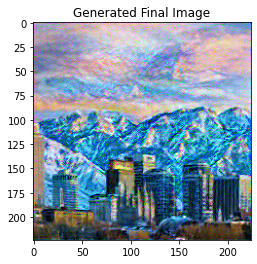

In [ ]:
# Start with a copy of the content image
generated_image = content_image.clone().requires_grad_(True)

epoch = 7000
lr = 0.1 # trying learning rate of 0.1
alpha = 0.001
beta = 1

vgg_generated_model = VGGIntermediate(style_layers).cuda().eval() # creating a third model
optimizer = optim.Adam([generated_image], lr=lr) # learn on the generated image


# Run the optimizer on the images to change the image using the loss of the style and content layers to backpropagate errors 
for e in range(epoch):
  
  with torch.no_grad():
    generated_image.clamp_(0, 1)

  optimizer.zero_grad()
  generated_features = vgg_generated_model(generated_image)

  # Calculating content loss
  content_layer_loss(generated_features[content_layer[0]])

  # Calculating sytle loss
  style_layer_loss1(generated_features[style_layers[0]])
  style_layer_loss2(generated_features[style_layers[1]])
  style_layer_loss3(generated_features[style_layers[2]])
  style_layer_loss4(generated_features[style_layers[3]])
  style_layer_loss5(generated_features[style_layers[4]])


  content_loss = content_layer_loss.loss
  style_loss = style_layer_loss1.loss + style_layer_loss2.loss + style_layer_loss3.loss + style_layer_loss4.loss + style_layer_loss4.loss

  # Calculating total loss
  total_loss = (alpha * content_loss) + (beta * style_loss)

  total_loss.backward()
  optimizer.step()

  if e % 50 == 0:
    print(f'epoch {e}, content loss: {content_loss.item():.5f}, style loss: {style_loss.item():.5f}')


# Show the image
plt.figure()
display(generated_image, title='Generated Final Image')

### Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

Equation 1: The loss of the content image at a given layer (l) is determined by the sum squared error (divided by 2) between the features representation of the content image (p) and the generated image (x). The feature representation of both images (F and P) are matrices of size N X M, where N represents the number of features maps at the given layer and M represents the height of the feature representation multiplied by the width. F and P are calculated by using the activations of the ith filter at position j in the given layer, l.






Equation 3: The feature correlations of the style image (G subscript i,j) are calculated by taking the activations of the style image at layer (l) and calculating the inner product between the vectorized feature map i and j in layer l. The matrix F and the transposed matrix F are both of size N * M, where N represents the number of feature maps and M represents the height of the feature representation multiplied by the width. 


Equation 4: The contribution of a given layer to the style loss (E subscript l) is calculated from the mean squared distance between the Gram matrix from the original style image (A) and the Gram matrix from the generated image (G). The variable A subscript i, j at layer (l) comes from equation 3 (as described in the previous sentence) and G subscript i, j at layer (l) likewise comes from equation 3. The sum of the mean squared distance between these two Gram matrices is calculated and then divided by the product of 4, N, and M at the given layer (l). N is the number of channels and M is the the height times width in the feature representation of the given layer, l


Equation 5: The total style loss from the original sytle image (a) and the generated image (x) is calculated by summing the weighted average of the contributions of each layer to the sytle loss (E subscript l). In the paper, the variable W subscript l is always equal to one divided by the number of layers.